Convergence study in the exterior region.

Added mass dependencies: outermost (h-d)/radwidth (if heaving), h/(h-d) (outermost)

Damping dependencies: m0h, outermost region (h-d)/radwidth (if heaving)

(m0h is the most important, impacts of others are less clear)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pickle
import pandas as pd
from numpy import random

import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))
from convergence_problem import ConvergenceProblem
from helpers import *

In [2]:
# Define class for convergence study in exterior region
class ConvergenceProblemE(ConvergenceProblem):
  def convergence_study_over_m0s(self, nmk_max, m0s): # First m0 should be the one given in Problem instantiation
    full_a_matrix = self.a_matrix()
    output = {}
    b_vector_lst = []
    c_vector_lst = [] # If inner regions don't change in NMK, c_vectors are the same.
    for i in range(self.boundary_count):
      self.heaving = [1 if index == i else 0 for index in range(self.boundary_count)]
      b_vector_lst.append(self.b_vector())
      c_vector_lst.append(self.c_vector())
    
    for m0 in m0s:
      out_for_m0 = {}
      if m0 != self.m0:
          self.change_m0(m0)
          full_a_matrix = self.a_matrix_from_old(full_a_matrix)
          for i in range(self.boundary_count):
            self.heaving = [1 if index == i else 0 for index in range(self.boundary_count)]
            b_vector_lst[i] = self.b_vector_from_old(b_vector_lst[i])
      all_a_matrices = self.get_sub_matrices(full_a_matrix, nmk_max)
      omega = self.angular_freq(self.m0)

      for i in range(self.boundary_count):
        self.heaving = [1 if index == i else 0 for index in range(self.boundary_count)]
        full_b_vector = b_vector_lst[i]
        full_c_vector = c_vector_lst[i]
        all_b_vectors = self.get_sub_vectors(full_b_vector, nmk_max)
        particular_contribution = self.int_phi_p_i(i) # only region i is heaving
        am_lst = []
        dp_lst = []
        for nmk in range(1, nmk_max + 1):
          x = self.get_unknown_coeffs(all_a_matrices[nmk - 1], all_b_vectors[nmk - 1])
          raw_hydro = 2 * np.pi * (np.dot(full_c_vector, x[:-nmk]) + particular_contribution)
          # follow the capytaine convention
          am_lst.append(raw_hydro.real * self.rho) # added mass
          dp_lst.append(raw_hydro.imag * omega * self.rho) # damping
        out_for_m0["ams" + str(i)] = am_lst
        out_for_m0["dps" + str(i)] = dp_lst
        x = self.get_unknown_coeffs(full_a_matrix, full_b_vector)
        am, dp = self.hydro_coeffs(x, "capytaine")
        out_for_m0["am" + str(i)] = am
        out_for_m0["dp" + str(i)] = dp
      output[m0] = out_for_m0
    return output
  
  def get_sub_matrices(self, full_a_matrix, nmk_max):
    big_nmk = self.NMK[-1]
    all_a_matrices = []
    for i in range(1, nmk_max + 1):
      a_matrix = full_a_matrix[: (self.size - big_nmk + i), : (self.size - big_nmk + i)]
      all_a_matrices.append(a_matrix)
    return all_a_matrices

  def get_sub_vectors(self, full_vector, nmk_max):
    big_nmk = self.NMK[-1]
    all_b_vectors = []
    for i in range(1, nmk_max + 1):
      b_vector = full_vector[: (self.size - big_nmk + i)]
      all_b_vectors.append(b_vector)
    return all_b_vectors

In [3]:
hs = list(np.linspace(5, 50, 10))
uniform_m0s = list(np.linspace(0.5, 5, 10))
ds = [[1, 2, 3], [2, 3, 2], [3, 2, 1]]
a_s = [[1, 2, 3], [0.5, 1.5, 3.5], [2, 3, 3.5]]
big_nmk = 200
nmk_max = 150

NMK = [big_nmk] * 4
rho = 1023

file1 = "predetermined-configs.pkl"
file2 = "random-configs.pkl"

In [4]:
# Functions to generate random configurations
def random_d_a(h):
  # need (h-d)/radwidth > 1 to avoid overflows
  d, a, radwidths = [], [], []
  for i in range(3):
    di = random.uniform(low = 0.0, high = (h - 1))
    rad_width_i = random.uniform(low = 0, high = (h - di))
    d.append(di)
    radwidths.append(rad_width_i)
    a.append(sum(radwidths))
  return d, a

def random_m0s(h):
  # need m0 * h < 75
  return list(random.uniform(low=0.0, high=(75/h), size = 5))


In [5]:
# Generate file1, file2 data (commented out)
# data = []
# for h in hs:
#   for d in ds:
#     for a in a_s:
#       data_dict = {"h" : h,
#                    "d" : d,
#                    "a" : a}
#       prob = ConvergenceProblemE(h, d, a, [1, 1, 1, 1], NMK, m0s[0], rho)
#       results = prob.convergence_study_over_m0s(nmk_max, m0s)
#       data.append(merge_dicts(data_dict, results))
#       update_data_file(data, file1)
#       print("Finished run through an a.")
#     print("Finished run through a d.")
#   print("Finished run through an h.")


# data = []
# for h in hs:
#   for i in range(4): # 4 physical configurations per.
#     m0s = random_m0s(h)
#     d, a = random_d_a(h)
#     data_dict = {"h" : h,
#                   "d" : d,
#                   "a" : a,
#                   "m0s" : m0s}
#     prob = ConvergenceProblemE(h, d, a, [1, 1, 1], NMK, m0s[0], rho)
#     results = prob.convergence_study_over_m0s(nmk_max, m0s)
#     data.append(merge_dicts(data_dict, results))
#     update_data_file(data, "random_e_convergence.pkl")
#     print("Finished a config.")
#   print("Finished run through an h.")


In [6]:
# Load file1, file2 data, add convergence information

predet_data = open_pkl_file(file1)
random_data = open_pkl_file(file2)

def convergence_point(data_dict, hydro, region, error): # modified convergence point functions for this data structure
  hydros = data_dict[hydro + "s" + str(region)]
  true_value = data_dict[hydro + str(region)]
  incumbent = len(hydros)
  for nmk in range(len(hydros), 0, -1):
    if abs((hydros[nmk - 1] - true_value)/true_value) <= error:
      incumbent = nmk
    else: # after this point, consistently <= error away.
      break
  return incumbent

def generate_convergence_data(data, error_lst):
  # Modifies the given list of dictionaries in place.
  hydro_keys = ["am", "dp"]
  for data_dict in data:
    for m0 in data_dict["m0s"]:
      for hydro in hydro_keys:
          for error in error_lst:
            for region in range(len(data_dict["d"])):
              data_dict[m0][f"convergence point {error:.2g} " + hydro + str(region)] = convergence_point(data_dict[m0], hydro, region, error)

errors = [0.01, 0.005]
generate_convergence_data(predet_data, errors)
generate_convergence_data(random_data, errors)

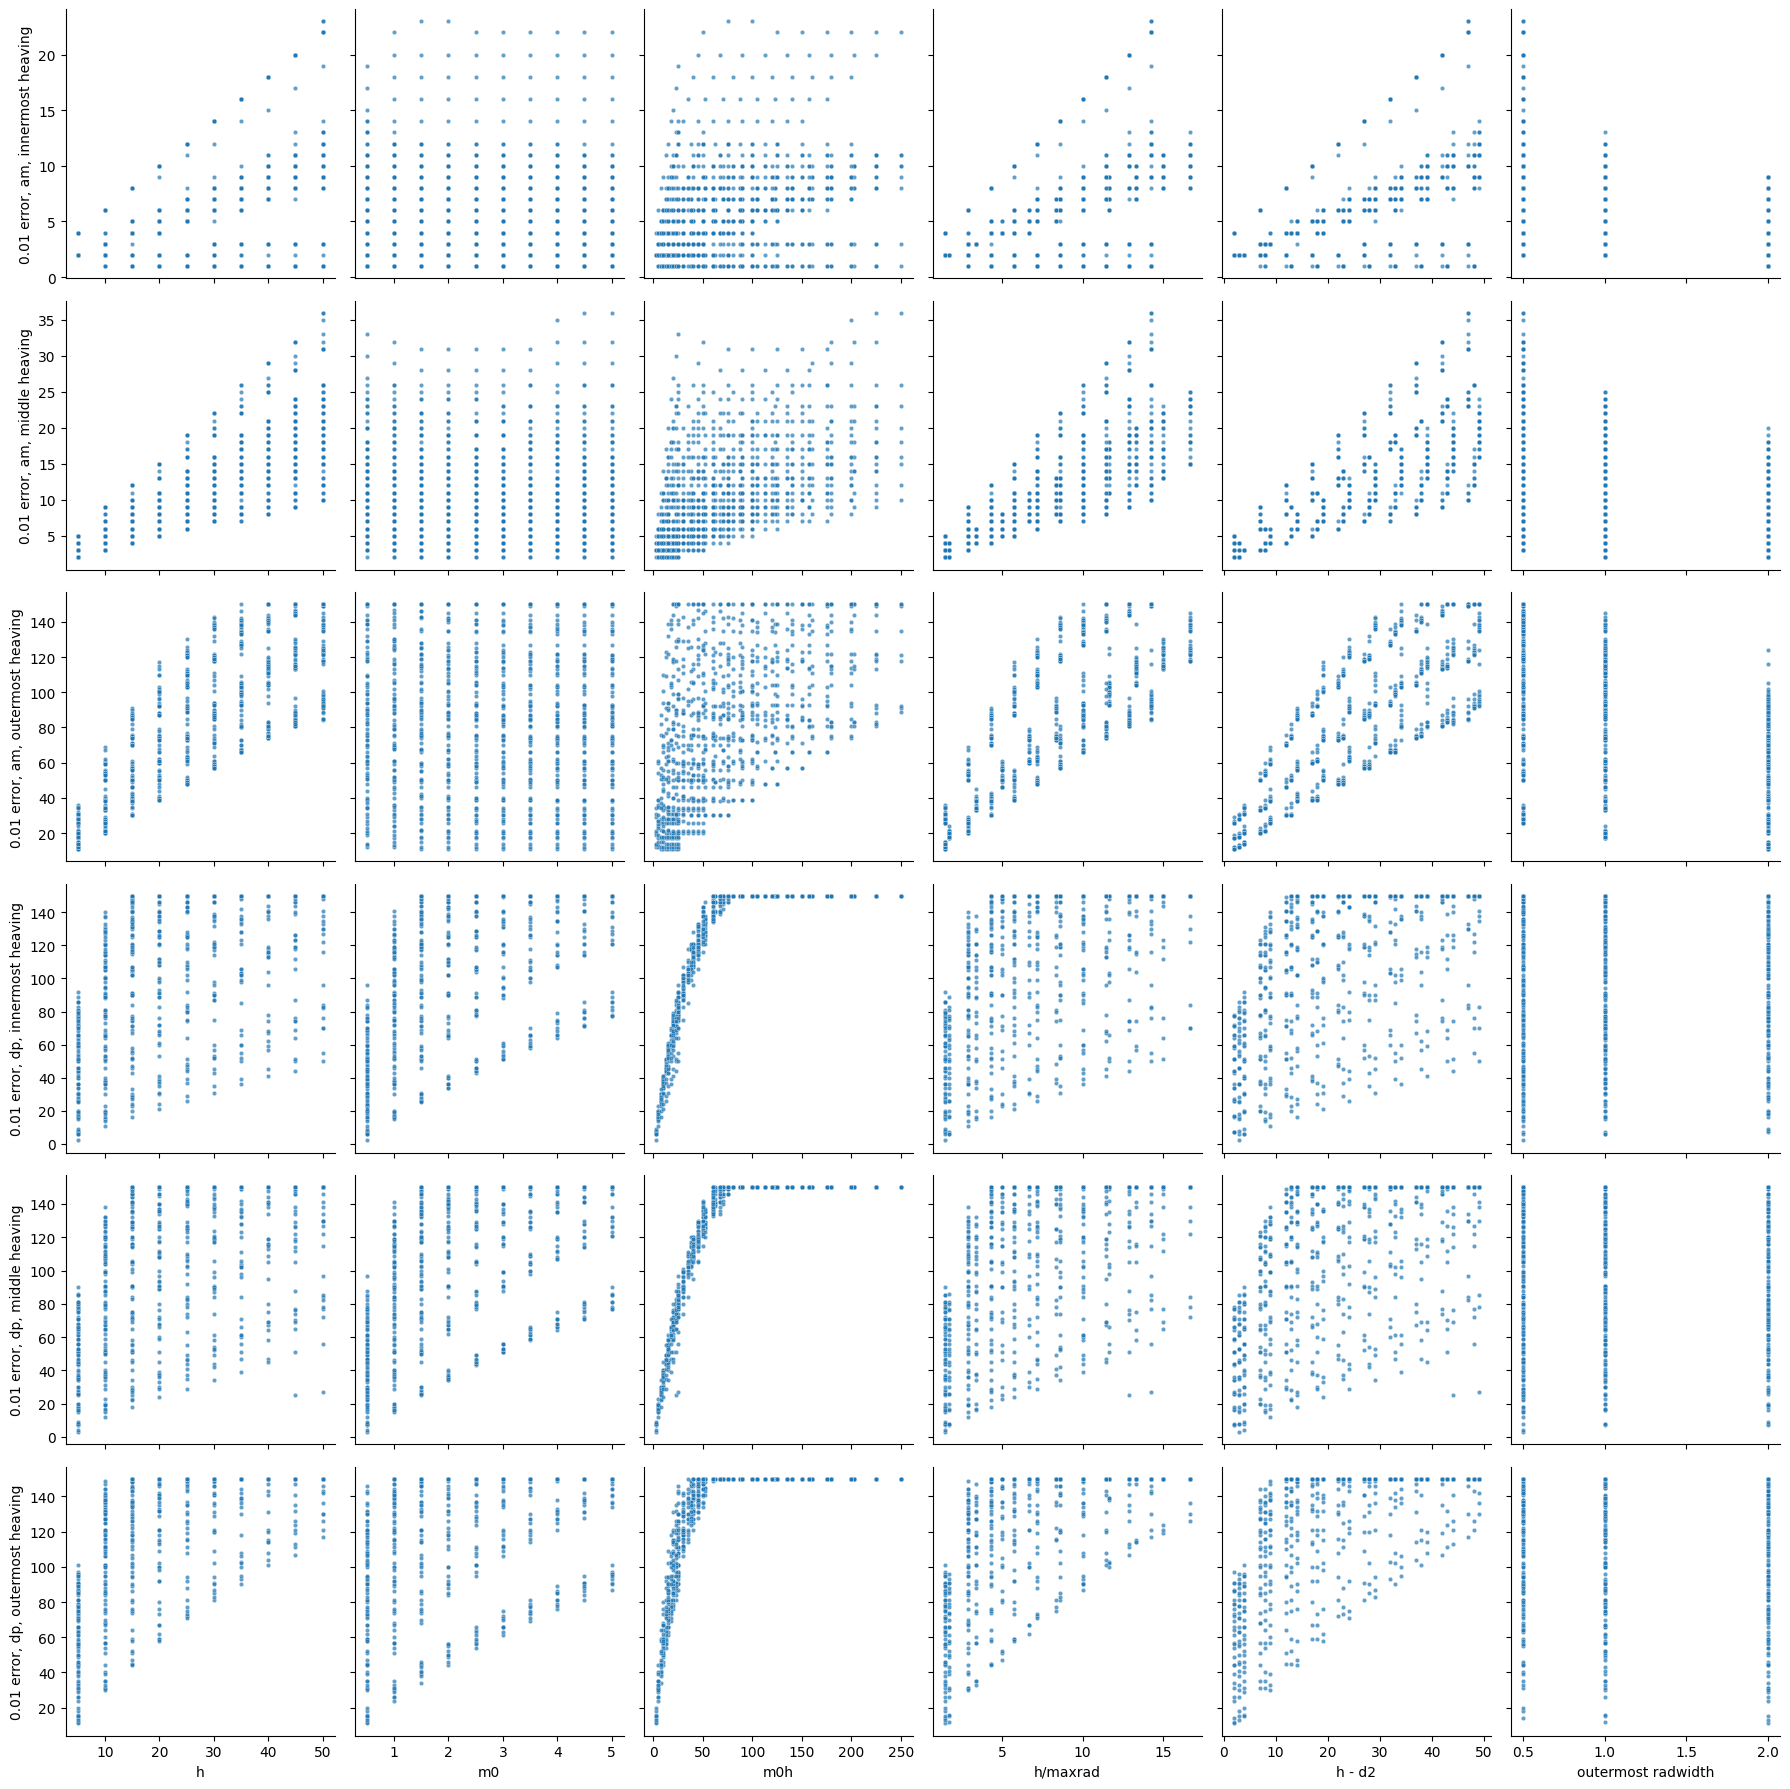

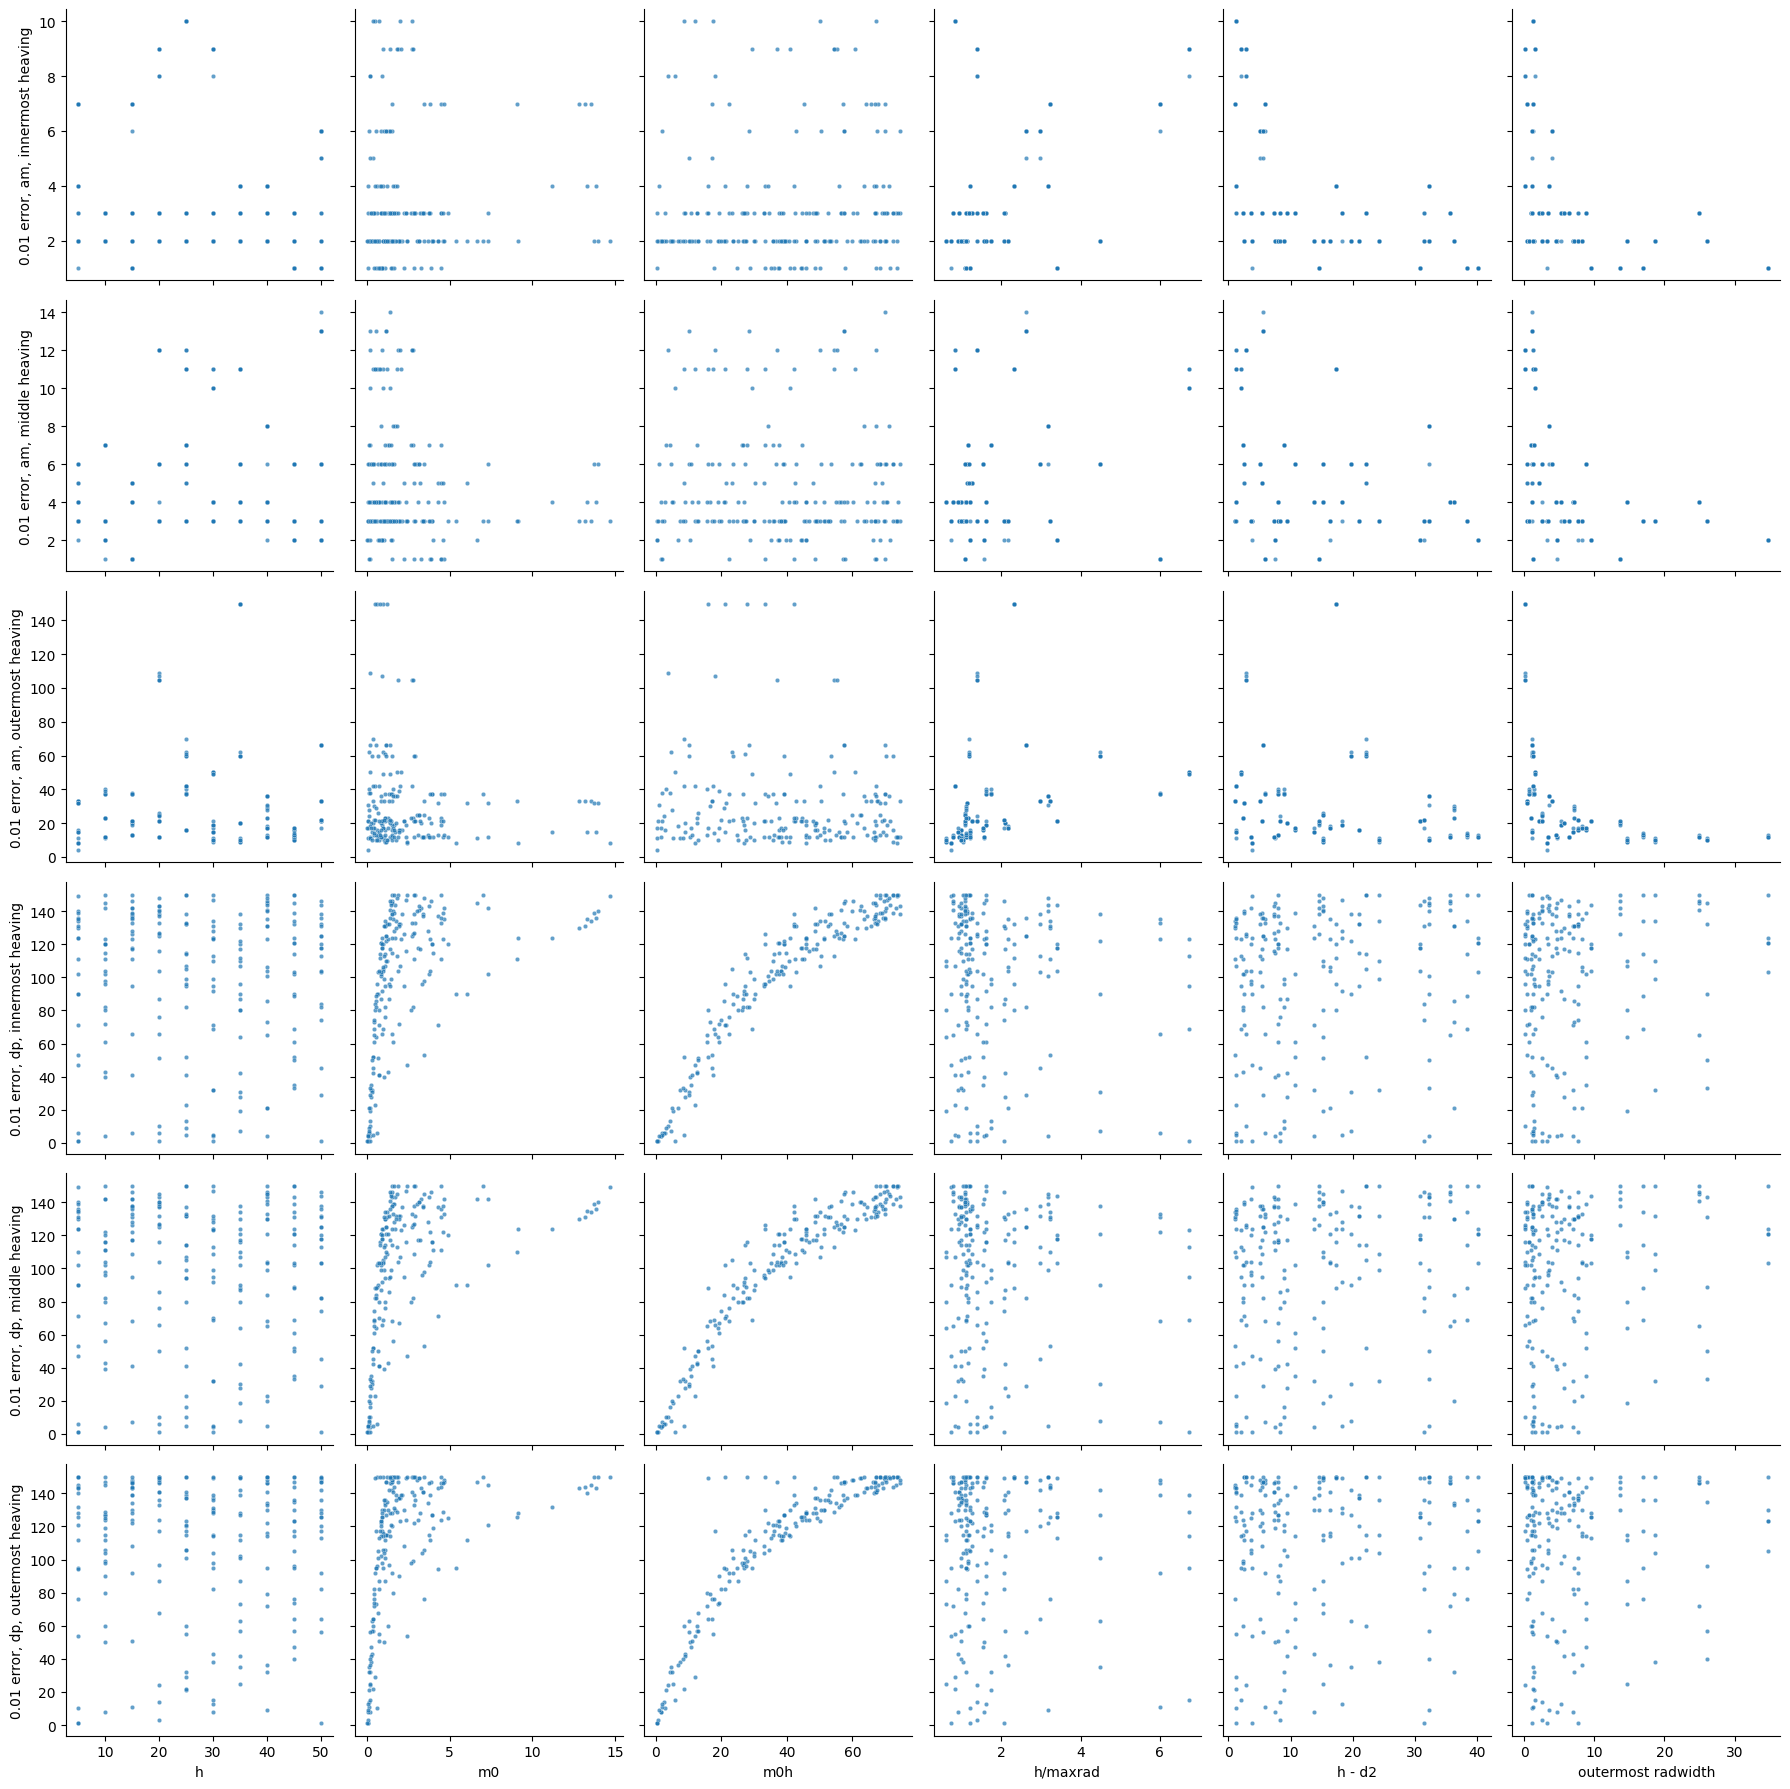

In [7]:
# Plot convergence point on y, m0, h, and m0h on x.
def yf1(config, m0, hydro, region, error):
  return config[m0]["convergence point " + str(error) + " " + hydro + str(region)]

x_funcs = {"h" : lambda cf, m0 : cf["h"],
           "m0" : lambda cf, m0 : m0,
           "m0h" : lambda cf, m0 : cf["h"] * m0,
           "h/maxrad" : lambda cf, m0 : cf["h"]/cf["a"][-1],
           "h - d2" : lambda cf, m0 : (cf["h"] - cf["d"][-1]),
           "outermost radwidth" : lambda cf, m0 : (cf["a"][-1] - cf["a"][-2])}

y_funcs = {"0.01 error, am, innermost heaving" : lambda cf, m0 : yf1(cf, m0, "am", 0, 0.01),
           "0.01 error, am, middle heaving" : lambda cf, m0 : yf1(cf, m0, "am", 1, 0.01),
           "0.01 error, am, outermost heaving" : lambda cf, m0 : yf1(cf, m0, "am", 2, 0.01),
           "0.01 error, dp, innermost heaving" : lambda cf, m0 : yf1(cf, m0, "dp", 0, 0.01),
           "0.01 error, dp, middle heaving" : lambda cf, m0 : yf1(cf, m0, "dp", 1, 0.01),
           "0.01 error, dp, outermost heaving" : lambda cf, m0 : yf1(cf, m0, "dp", 2, 0.01),}

plot_relation_grid(predet_data, x_funcs, y_funcs)
plot_relation_grid(random_data, x_funcs, y_funcs)

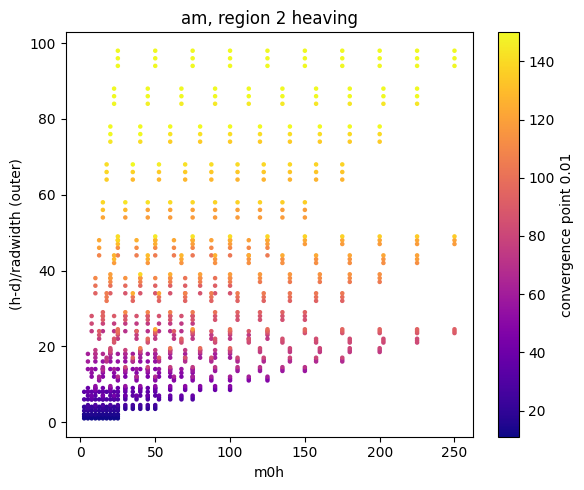

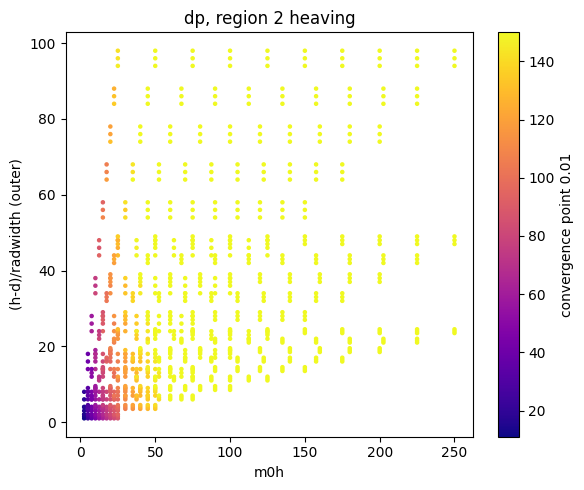

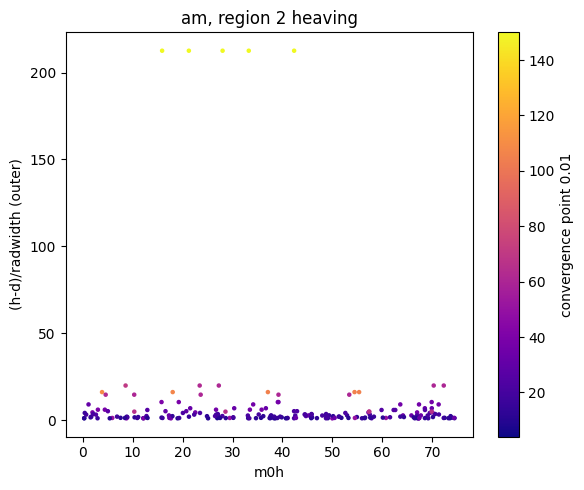

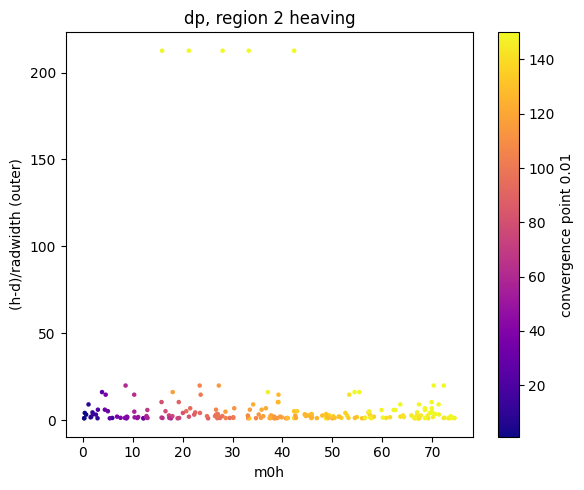

In [8]:
# Plot against both (h-d)/radwidth (outermost) and m0h, with color displaying when it was converged.
def plot_hydros_radwidth_m0h(data, hydro, region, error,
                             xf = (lambda cf, m0 : m0 * cf["h"]),
                             yf = (lambda cf, m0 : (cf["h"] - cf["d"][-1])/(cf["a"][-1] - cf["a"][-2])),
                             xlab = "m0h", ylab = "(h-d)/radwidth (outer)"):
  xs, ys, zs = [], [], []
  for data_dict in data:
    for m0 in data_dict["m0s"]:
      zs.append(data_dict[m0][f"convergence point {error:.2g} " + hydro + str(region)])
      xs.append(xf(data_dict, m0))
      ys.append(yf(data_dict, m0))
  data = np.column_stack((xs, ys, zs))
  plot_3tuples_2d(data, xlabel = xlab, ylabel = ylab, clabel = f"convergence point {error:.2g}",
                  title = hydro + ", region " + str(region) + " heaving")

plot_hydros_radwidth_m0h(predet_data, "am", 2, 0.01)
plot_hydros_radwidth_m0h(predet_data, "dp", 2, 0.01)
plot_hydros_radwidth_m0h(random_data, "am", 2, 0.01)
plot_hydros_radwidth_m0h(random_data, "dp", 2, 0.01)

In [9]:
# Generate more data (commented out). Run configs for various m0h, uniformly at random distributed (h - d)/radwidth from 1 to 200.
file3 = "ratioed-outer-region.pkl"
def random_h_minus_d_a(h):
  # need radwidth/(h-d) < 1
  h_minus_d_over_radwidth = random.uniform(low = 1., high = 200.)
  d = []
  a = []
  rad_widths = []
  for i in range(2): # Inner two regions
    di = random.uniform(low = 0.0, high = (h - 1))
    rad_width_i = random.uniform(low = 0, high = (h - di))
    d.append(di)
    rad_widths.append(rad_width_i)
    a.append(sum(rad_widths))
  # Outer region
  di = random.uniform(low = 0.0, high = (h - 1))
  rad_width_i = (h - di) / h_minus_d_over_radwidth
  d.append(di)
  rad_widths.append(rad_width_i)
  a.append(sum(rad_widths))
  return d, a

# data = []
# for h in hs:
#   for i in range(4): # 4 physical configurations per.
#     m0s = random_m0s(h)
#     d, a = random_h_minus_d_a(h)
#     data_dict = {"h" : h,
#                   "d" : d,
#                   "a" : a,
#                   "m0s" : m0s}
#     prob = ConvergenceProblemE(h, d, a, [1, 1, 1], NMK, m0s[0], rho)
#     results = prob.convergence_study_over_m0s(nmk_max, m0s)
#     data.append(merge_dicts(data_dict, results))
#     update_data_file(data, file3)
#     print("Finished a config.")
#   print("Finished run through an h.")

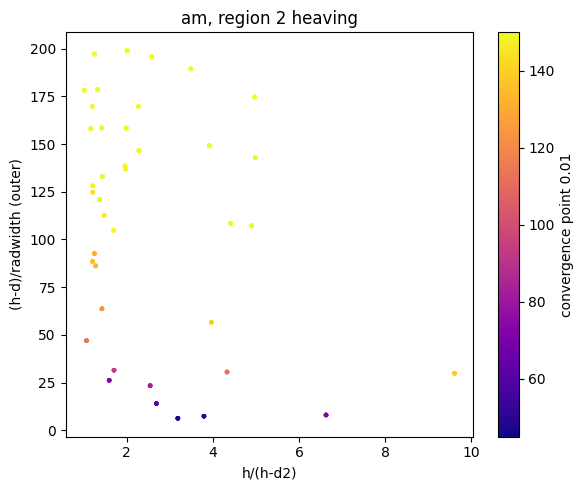

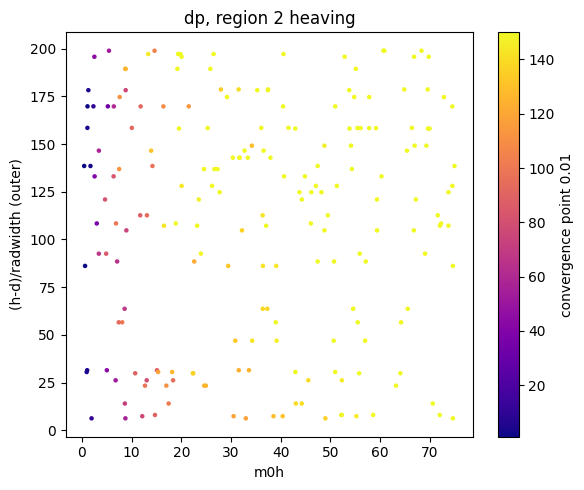

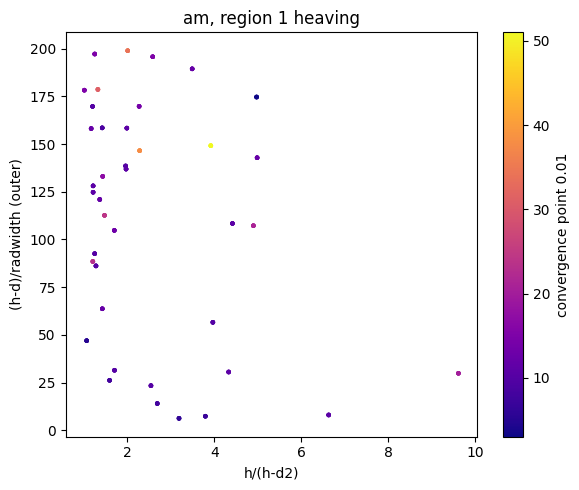

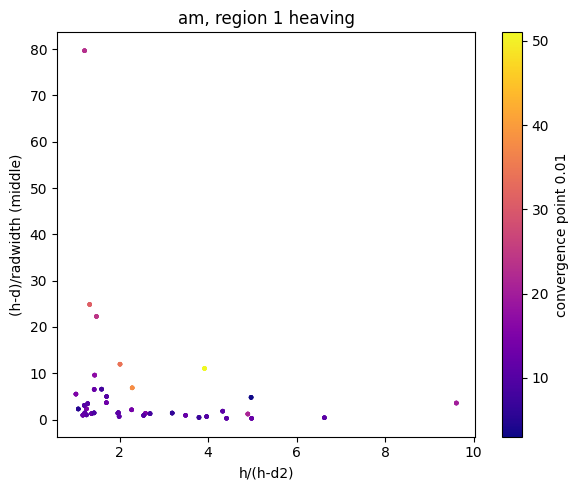

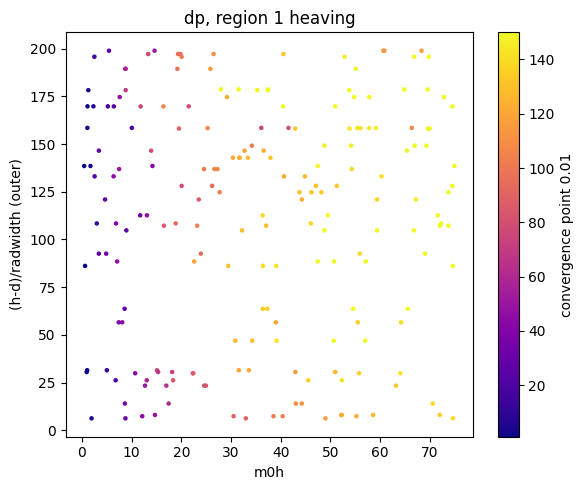

In [10]:
ratio_data = open_pkl_file(file3)
generate_convergence_data(ratio_data, errors)

plot_hydros_radwidth_m0h(ratio_data, "am", 2, 0.01, xf = (lambda cf, m0 : cf["h"]/(cf["h"]-cf["d"][2])), xlab = "h/(h-d2)")
plot_hydros_radwidth_m0h(ratio_data, "dp", 2, 0.01)
plot_hydros_radwidth_m0h(ratio_data, "am", 1, 0.01, xf = (lambda cf, m0 : cf["h"]/(cf["h"]-cf["d"][2])), xlab = "h/(h-d2)")
plot_hydros_radwidth_m0h(ratio_data, "am", 1, 0.01, xf = (lambda cf, m0 : cf["h"]/(cf["h"]-cf["d"][2])), xlab = "h/(h-d2)",
                         yf = (lambda cf, m0 : (cf["h"] - cf["d"][-1])/(cf["a"][1] - cf["a"][0])), ylab = "(h-d)/radwidth (middle)")
plot_hydros_radwidth_m0h(ratio_data, "dp", 1, 0.01)